In [1]:
import pandas as pd
train_data = pd.read_excel('/kaggle/input/adobe-nlp/behaviour_simulation_train.xlsx',index_col='id')

In [2]:
import pandas as pd
import numpy as np
import requests
import os
import gc
from tqdm import tqdm
from urllib.parse import urlparse
import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from multiprocessing import Pool
from transformers import AutoTokenizer, AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_embedding_model():
    model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
    # features = list(model.children())[:-1]
    # embedding_size = 128
    # features.extend([
    #     torch.nn.AdaptiveAvgPool2d(1),
    #     torch.nn.Flatten(),
    #     torch.nn.Linear(1280, embedding_size)
    # ])
    # embedding_model = torch.nn.Sequential(*features).to(device)
    # embedding_model.eval()
    model.to(device)
    model.eval()
    return model

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def extract_url(media_string):
    if pd.isna(media_string):
        return None
    if 'Photo' in media_string:
        return media_string.split("previewUrl='")[1].split("'")[0]
    else:
        return media_string.split("thumbnailUrl='")[1].split("'")[0]
    return None

def download_media(url, save_dir):
    try:
        response = requests.get(url, stream=True, timeout=10)
        if response.status_code == 200:
            file_name = os.path.basename(urlparse(url).path)
            file_path = os.path.join(save_dir, file_name)
            with open(file_path, 'wb') as f:
                for chunk in response.iter_content(1024):
                    f.write(chunk)
            return file_path
        else:
            return None
    except requests.RequestException:
        return None

def download_media_parallel(urls, save_dir):
    with Pool() as pool:
        return pool.starmap(download_media, [(url, save_dir) for url in urls if url])

def get_batch_embeddings(img_paths, model, batch_size=32):
    embeddings = []
    for i in range(0, len(img_paths), batch_size):
        batch_paths = img_paths[i:i+batch_size]
        batch_imgs = [Image.open(path, mode='r', formats=['JPEG', 'PNG']).convert('RGB') for path in batch_paths if isinstance(path, str) and os.path.exists(path)]
        if batch_imgs:
            batch_tensors = torch.stack([transform(img) for img in batch_imgs]).to(device)
            with torch.no_grad():
                batch_embeddings = model(batch_tensors).cpu().numpy()
            embeddings.extend(batch_embeddings)
    return embeddings

def get_bertweet_embeddings(texts, model, tokenizer, max_length=128, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating BERTweet embeddings"):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", max_length=max_length, truncation=True, padding="max_length")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # CLS token
        embeddings.extend(batch_embeddings)
        del inputs, outputs, batch_embeddings
        torch.cuda.empty_cache()
    return np.array(embeddings)

def preprocessing(df, save_dir='/kaggle/working/adobe/'):
    # Date feature extraction
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month
    df['is_weekend'] = (df['date'].dt.dayofweek>=5)*1
    df['is_month_start'] = df['date'].dt.is_month_start*1
    df['is_month_end'] = df['date'].dt.is_month_end*1
    df['day'] = df['date'].dt.day
    df = df.drop('date', axis=1)
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Image processing
    df['media_url'] = df['media'].apply(extract_url)
    df['local_path'] = download_media_parallel(df['media_url'].dropna().tolist(), save_dir)
    df['local_path'] = df['local_path'].apply(lambda x: x if x and os.path.exists(x) else None)
    valid_paths = df['local_path'].dropna().tolist()
    
    embedding_model = get_embedding_model()
    image_embeddings = get_batch_embeddings(valid_paths, embedding_model, batch_size=16)
    image_embedding_df = pd.DataFrame(image_embeddings, columns=[f'image_embedding_{i}' for i in range(1000)])
    df = pd.concat([df.reset_index(drop=True), image_embedding_df], axis=1)
    
    # Text processing
    df['combined_text'] = 'username : ' + df['username'] + ' '+ 'comapny : ' + df['inferred company']+'content : '+df['content'] 
    
    tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=True)
    model = AutoModel.from_pretrained("vinai/bertweet-base").to(device)
    model.eval()
    
    bertweet_embeddings = get_bertweet_embeddings(df['combined_text'].tolist(), model, tokenizer, batch_size=32)
    bertweet_embedding_df = pd.DataFrame(bertweet_embeddings, columns=[f'text_embedding_{i}' for i in range(768)])
    df = pd.concat([df, bertweet_embedding_df], axis=1)
    
    # Drop unnecessary columns
    df = df.drop(['media', 'media_url', 'local_path', 'content', 'username', 'inferred company', 'combined_text'], axis=1)
    
    gc.collect()
    torch.cuda.empty_cache()
    
    return df

In [3]:
import warnings
import os
warnings.filterwarnings('ignore')
testing = train_data.copy()
till = 10000
testing = preprocessing(testing[:till])

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 163MB/s]


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Generating BERTweet embeddings: 100%|██████████| 32/32 [00:04<00:00,  6.97it/s]


In [4]:
len(list(testing.columns))

1774

In [5]:
testing.head()

,likes,month,is_weekend,is_month_start,is_month_end,day,image_embedding_0,image_embedding_1,image_embedding_2,image_embedding_3,...,text_embedding_758,text_embedding_759,text_embedding_760,text_embedding_761,text_embedding_762,text_embedding_763,text_embedding_764,text_embedding_765,text_embedding_766,text_embedding_767
0,1,12,1,0,0,12,-0.132657,-0.637906,-2.511640,0.009061,...,0.109581,0.048969,-0.003208,0.041433,0.068599,-0.016013,-0.042945,-0.221615,-0.131004,0.017417
1,2750,6,1,0,1,30,0.491291,0.209268,-0.033724,-1.931293,...,0.183375,0.051587,0.034564,-0.073746,0.265690,-0.143621,0.122211,-0.104689,-0.242918,-0.003308
2,57,9,0,0,0,29,-0.061185,1.653488,1.154053,-0.213712,...,0.133224,0.045438,-0.021889,0.087877,-0.011531,-0.087014,0.096057,-0.116086,-0.164340,-0.053712
3,152,10,0,1,0,1,-2.004738,-0.289126,-0.729562,0.721084,...,0.082127,0.030091,0.119243,-0.093048,0.225192,-0.028532,0.088843,0.033127,-0.139336,-0.252549
4,41,10,0,0,0,19,-0.995871,-1.993809,-0.966511,-0.360755,...,0.254545,-0.017587,0.089886,0.100898,0.054707,-0.076007,-0.068115,-0.238209,-0.111949,-0.041877


Fold 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48
[LightGBM] [Info] Number of data points in the train set: 666, number of used features: 3
[LightGBM] [Info] Start training from score 631.009009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

I0000 00:00:1728726123.177598     112 service.cc:145] XLA service 0x78a9bc00a7f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728726123.177653     112 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1728726126.408109     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Neural Network RMSE: 1832.9681

Fold 2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48
[LightGBM] [Info] Number of data points in the train set: 667, number of used features: 3
[LightGBM] [Info] Start training from score 376.293853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

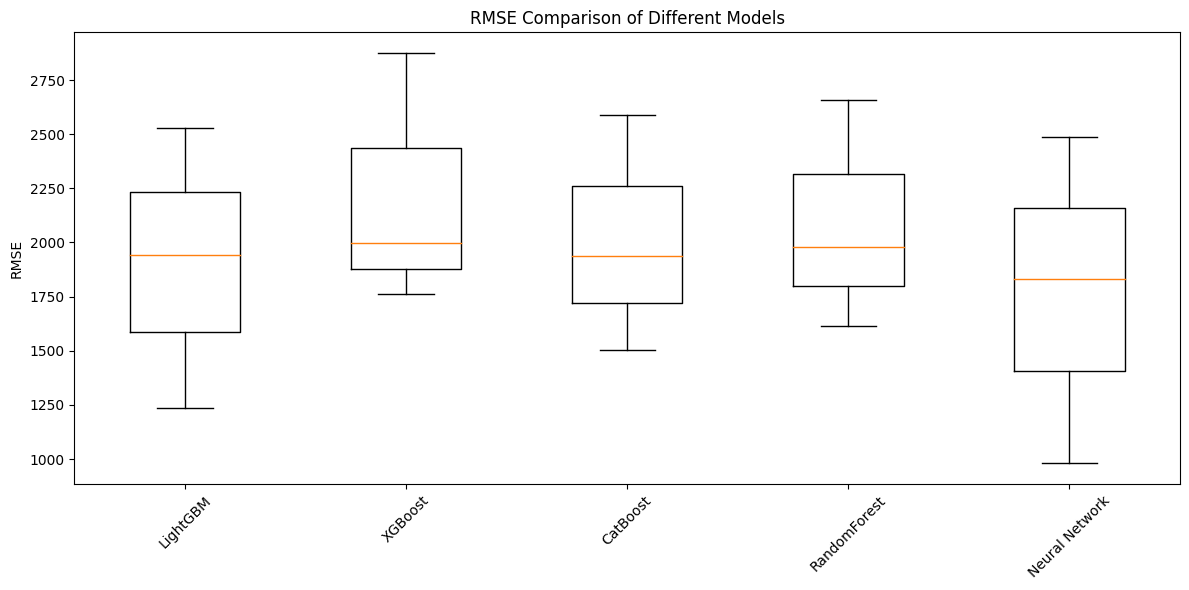

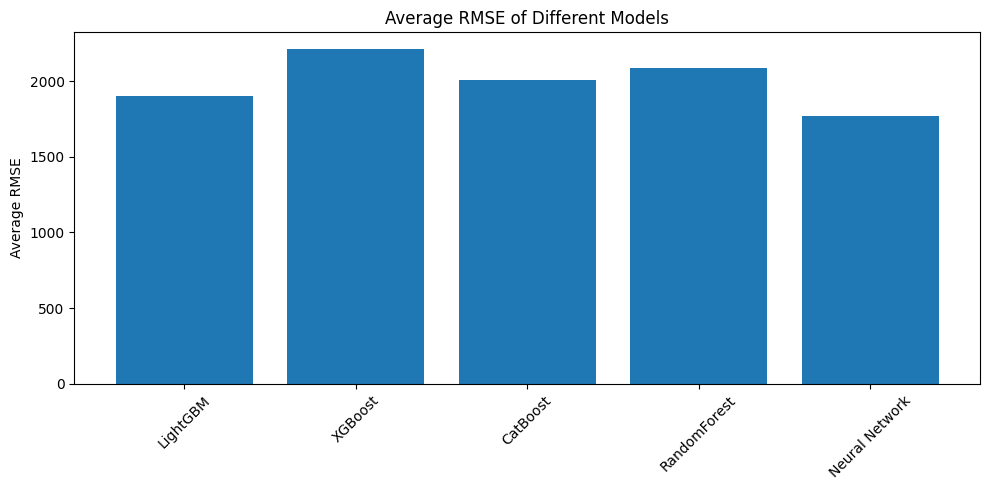


Average RMSE scores:
LightGBM: 1901.5672
XGBoost: 2211.6999
CatBoost: 2009.4895
RandomForest: 2084.3877
Neural Network: 1767.6432

Best performing model: Neural Network


In [6]:
import warnings
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

df = testing
# Select features
date_cols = ['month', 'day', 'is_month_start','is_month_end', 'is_weekend']
X = df[date_cols]
y = df['likes']
groups = train_data['inferred company'].iloc[:till]
X = X.fillna(0)

# Convert datetime columns to numeric
for col in X.select_dtypes(include=['datetime64']).columns:
    X[col] = X[col].astype(int) // 10**9  # Convert to Unix timestamp

# Initialize models
models = {
    'LightGBM': LGBMRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(random_state=42, verbose=0),
    'RandomForest': RandomForestRegressor(random_state=42)
}

# Function to create neural network
def create_nn_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Initialize GroupKFold
gkf = GroupKFold(n_splits=3)

# Dictionary to store RMSE scores
rmse_scores = {model_name: [] for model_name in models.keys()}
rmse_scores['Neural Network'] = []

# Perform GroupKFold cross-validation
for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    print(f"Fold {fold}")
    
    # Train and evaluate all models
    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores[model_name].append(rmse)
        print(f"{model_name} RMSE: {rmse:.4f}")
    
    # Train and evaluate Neural Network
    nn_model = create_nn_model(X_train_scaled.shape[1])
    nn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)
    y_pred = nn_model.predict(X_val_scaled).flatten()
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores['Neural Network'].append(rmse)
    print(f"Neural Network RMSE: {rmse:.4f}")
    
    print()

# Calculate average RMSE for each model
avg_rmse = {model: np.mean(scores) for model, scores in rmse_scores.items()}

# Visualization
plt.figure(figsize=(12, 6))
plt.boxplot([rmse_scores[model] for model in rmse_scores.keys()], labels=list(rmse_scores.keys()))
plt.title('RMSE Comparison of Different Models')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bar plot for average RMSE
plt.figure(figsize=(10, 5))
plt.bar(avg_rmse.keys(), avg_rmse.values())
plt.title('Average RMSE of Different Models')
plt.ylabel('Average RMSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print average RMSE and best model
print("\nAverage RMSE scores:")
for model, avg_score in avg_rmse.items():
    print(f"{model}: {avg_score:.4f}")

best_model = min(avg_rmse, key=avg_rmse.get)
print(f"\nBest performing model: {best_model}")